In [ ]:
# Config
seed = 42  # for reproducibility
training_split_ratio = 0.8  # use 90% of samples for training, 10% for testing


# If the following values are False, the models will be downloaded and not computed
compute_histograms = False
train_whole_images = False 
train_patches = False

In [ ]:
import copy
import enum
from random import *
import warnings
import tempfile
import subprocess
import multiprocessing
from pathlib import Path

import torch
import torch.nn.functional as F
from torchvision.utils import make_grid, save_image
import random; random.seed(seed)

import torchio as tio
from torchio import AFFINE, DATA

import numpy as np
import nibabel as nib
from unet import UNet
from scipy import stats
import SimpleITK as sitk
import matplotlib.pyplot as plt

from IPython import display
from tqdm.notebook import tqdm
#from livelossplot import PlotLosses

print('TorchIO version:', tio.__version__)

In [ ]:
# Dataset
dataset_dir_name = 'nifti_data'
dataset_dir = Path(dataset_dir_name)
histogram_landmarks_path = 'landmarks.npy'

In [ ]:
images_dir = dataset_dir / 'image'
labels_dir = dataset_dir / 'mask'
image_paths = sorted(images_dir.glob('*.nii.gz'))
label_paths = sorted(labels_dir.glob('*.nii.gz'))
assert len(image_paths) == len(label_paths)

subjects = []
for (image_path, label_path) in zip(image_paths, label_paths):
    subject = tio.Subject(
        mri=tio.ScalarImage(image_path),
        mask=tio.LabelMap(label_path),
    )
    subjects.append(subject)
dataset = tio.SubjectsDataset(subjects)
print('Dataset size:', len(dataset), 'subjects')

In [ ]:
## image data visualization function

def plot_image_and_mask(imgset, maskset):
    fig, axs = plt.subplots(len(imgset[0,0,0,:])-1,2, figsize=(10,100))
    count = 0
    for i in range(len(imgset[0,0,0,:])-1):
        axs[count][0].title.set_text("MRI T2 WI rectal") # set title
        axs[count][0].imshow(np.transpose(imgset[:,:,:,i],(1,2,0)),cmap='gray') # show MRI 
        axs[count][1].title.set_text("Mask") # plot title on the mask 
        axs[count][1].imshow(np.transpose(maskset[:,:,:,i],(1,2,0)),cmap='gray') # Show corresponding mask
        count += 1
    fig.tight_layout()


def image_visualization(dataset):
    index1 = randint(0,len(dataset)-1)
    subject_vis = dataset[index1]
    print(subject_vis.mri)
    imgset = subject_vis['mri'].data.numpy()
    maskset = subject_vis['mask'].data.numpy()
    plot_image_and_mask(imgset, maskset)

In [ ]:
image_visualization(dataset)

In [ ]:
#@title (Helper functions, double-click here to expand)
def show_nifti(image_path_or_image, colormap='gray'):
    if isinstance(image_path_or_image, nib.AnalyzeImage):
        nii = image_path_or_image
    else:
        image_path = image_path_or_image
        nii = nib.load(str(image_path))
    k = int(nii.shape[-1] / 2)
    plt.imshow(nii.dataobj[..., k], cmap=colormap)

def show_subject(subject, image_name, label_name=None):
    if label_name is not None:
        subject = copy.deepcopy(subject)
        affine = subject[label_name].affine
        label_image = subject[label_name].as_sitk()
        label_image = sitk.Cast(label_image, sitk.sitkUInt8)
        border = sitk.BinaryContour(label_image)
        border_array, _ = tio.io.sitk_to_nib(border)
        border_tensor = torch.from_numpy(border_array)[0]
        image_tensor = subject[image_name].data[0]
        image_tensor[border_tensor > 0.5] = image_tensor.max()
    with tempfile.NamedTemporaryFile(suffix='.nii') as f:
        subject[image_name].save('temp.nii')
        show_nifti('temp.nii')

In [ ]:
one_subject = dataset[0]
to_ras = tio.ToCanonical()
one_subject = to_ras(one_subject)
print(one_subject)
print(one_subject.mri)
show_subject(one_subject, 'mri', label_name='mask')

In [ ]:
landmarks = tio.HistogramStandardization.train(
    image_paths,
    output_path=histogram_landmarks_path,
)
np.set_printoptions(suppress=True, precision=3)
print('\nTrained landmarks:', landmarks)

In [ ]:
training_transform = tio.Compose([
    #tio.ToCanonical(),
    #tio.Resample(3),
    tio.CropOrPad((160, 160, 8),mask_name='mask'),
    #tio.RandomMotion(p=0.2),
    tio.HistogramStandardization({'mri': landmarks}),
    #tio.RandomBiasField(p=0.3),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.RandomNoise(p=0.1),
    tio.RandomFlip(axes=(0,)),
    #tio.OneOf({
    #    tio.RandomAffine(): 0.8,
    #    tio.RandomElasticDeformation(): 0.2,
    #}),
])

validation_transform = tio.Compose([
    #tio.ToCanonical(),
    #tio.Resample(3),
    tio.CropOrPad((160, 160, 8),mask_name='mask'),
    tio.HistogramStandardization({'mri': landmarks}),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
])

num_subjects = len(dataset)
num_training_subjects = int(training_split_ratio * num_subjects)

training_subjects = subjects[:num_training_subjects]
validation_subjects = subjects[num_training_subjects:]

training_set = tio.SubjectsDataset(
    training_subjects, transform=training_transform)

validation_set = tio.SubjectsDataset(
    validation_subjects, transform=validation_transform)

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')

In [ ]:
image_visualization(training_set)


In [ ]:
image_visualization(validation_set)

In [ ]:
training_batch_size = 8
validation_batch_size = 2 * training_batch_size

training_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size=training_batch_size,
    shuffle=True,
    num_workers=4,#multiprocessing.cpu_count(),
)

validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=validation_batch_size,
    num_workers=4,#multiprocessing.cpu_count(),
)

In [ ]:
one_batch = next(iter(training_loader))

In [ ]:
k = 7
batch_mri = one_batch['mri'][DATA][..., k]
batch_label = one_batch['mask'][DATA][..., k]
slices = torch.cat((batch_mri, batch_label))
image_path = 'batch_whole_images.png'
save_image(slices, image_path, nrow=training_batch_size, normalize=True, scale_each=True, padding=0)
display.Image(image_path)

In [18]:
#@title (Deep learning functions, double-click here to expand)
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
CHANNELS_DIMENSION = 1
SPATIAL_DIMENSIONS = 2, 3, 4

class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'

def prepare_batch(batch, device):
    inputs = batch['mri'][DATA].to(device)
    foreground = batch['mask'][DATA].to(device)
    background = 1 - foreground
    targets = torch.cat((background, foreground), dim=CHANNELS_DIMENSION)
    return inputs, targets

def get_dice_score(output, target, epsilon=1e-9):
    p0 = output
    g0 = target
    p1 = 1 - p0
    g1 = 1 - g0
    tp = (p0 * g0).sum(dim=SPATIAL_DIMENSIONS)
    fp = (p0 * g1).sum(dim=SPATIAL_DIMENSIONS)
    fn = (p1 * g0).sum(dim=SPATIAL_DIMENSIONS)
    num = 2 * tp
    denom = 2 * tp + fp + fn + epsilon
    dice_score = num / denom
    return dice_score

def get_dice_loss(output, target):
    return 1 - get_dice_score(output, target)

def forward(model, inputs):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        logits = model(inputs)
    return logits

def get_model_and_optimizer(device):
    model = UNet(
        in_channels=1,
        out_classes=2,
        dimensions=3,
        num_encoding_blocks=3,
        out_channels_first_layer=8,
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        activation='PReLU',
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters())
    return model, optimizer

def run_epoch(epoch_idx, action, loader, model, optimizer):
    is_training = action == Action.TRAIN
    epoch_losses = []
    model.train(is_training)
    for batch_idx, batch in enumerate(tqdm(loader)):
        inputs, targets = prepare_batch(batch, device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(is_training):
            logits = forward(model, inputs)
            probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
            batch_losses = get_dice_loss(probabilities, targets)
            batch_loss = batch_losses.mean()
            if is_training:
                batch_loss.backward()
                optimizer.step()
            epoch_losses.append(batch_loss.item())
    epoch_losses = np.array(epoch_losses)
    print(f'{action.value} mean loss: {epoch_losses.mean():0.3f}')
    return epoch_losses.mean()

def train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem):
    training_loss_values = []
    validation_loss_values = []
    best_val_loss = 1
    run_epoch(0, Action.VALIDATE, validation_loader, model, optimizer)
    for epoch_idx in range(1, num_epochs + 1):
        training_loss = 0.0
        val_loss = 0.0
        print('Starting epoch', epoch_idx)

        lv_t = run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer)
        training_loss += lv_t
        training_loss_values.append(training_loss)

        lv_v = run_epoch(epoch_idx, Action.VALIDATE, validation_loader, model, optimizer)
        val_loss += lv_v
        validation_loss_values.append(val_loss)
        if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), os.path.join(dataset_dir, "best_metric_model.pth"))
                print("saved new best metric model")

    plt.figure(figsize=(12,5))    
    plt.plot(training_loss_values)
    plt.plot(validation_loss_values)
    plt.title("3D Unet Model Loss")
    plt.ylabel("loss")
    plt.xlabel("Epochs")
    plt.legend(['train', 'val'])

  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.582
Starting epoch 1


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.507


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.595
saved new best metric model
Starting epoch 2


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.451


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.710
Starting epoch 3


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.443


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.730
Starting epoch 4


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.430


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.642
Starting epoch 5


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.449


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.555
saved new best metric model
Starting epoch 6


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.435


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.441
saved new best metric model
Starting epoch 7


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.407


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.463
Starting epoch 8


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.374


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.442
Starting epoch 9


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.401


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.432
saved new best metric model
Starting epoch 10


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.361


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.371
saved new best metric model
Starting epoch 11


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.387


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.356
saved new best metric model
Starting epoch 12


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.374


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.471
Starting epoch 13


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.365


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.352
saved new best metric model
Starting epoch 14


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.391


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.365
Starting epoch 15


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.371


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.363
Starting epoch 16


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.353


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.348
saved new best metric model
Starting epoch 17


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.356


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.349
Starting epoch 18


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.332


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.352
Starting epoch 19


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.327


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.322
saved new best metric model
Starting epoch 20


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.339


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.365
Starting epoch 21


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.319


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.310
saved new best metric model
Starting epoch 22


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.327


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.353
Starting epoch 23


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.336


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.341
Starting epoch 24


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.349


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.328
Starting epoch 25


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.300


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.343
Starting epoch 26


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.331


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.286
saved new best metric model
Starting epoch 27


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.285


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.411
Starting epoch 28


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.306


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.289
Starting epoch 29


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.272


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.324
Starting epoch 30


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.303


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.304
Starting epoch 31


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.262


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.282
saved new best metric model
Starting epoch 32


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.282


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.523
Starting epoch 33


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.294


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.272
saved new best metric model
Starting epoch 34


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.281


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.298
Starting epoch 35


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.290


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.310
Starting epoch 36


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.251


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.293
Starting epoch 37


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.245


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.362
Starting epoch 38


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.257


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294
Starting epoch 39


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.255


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.395
Starting epoch 40


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.261


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.328
Starting epoch 41


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.268


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.363
Starting epoch 42


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.274


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.276
Starting epoch 43


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.270


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.286
Starting epoch 44


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.228


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.327
Starting epoch 45


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.263


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.347
Starting epoch 46


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.269


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.389
Starting epoch 47


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.255


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.299
Starting epoch 48


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.229


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.312
Starting epoch 49


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.236


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.288
Starting epoch 50


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.244


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.366
Starting epoch 51


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.248


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.303
Starting epoch 52


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.270


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.252
saved new best metric model
Starting epoch 53


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.242


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.257
Starting epoch 54


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.266


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.289
Starting epoch 55


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.277


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.274
Starting epoch 56


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.250


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.333
Starting epoch 57


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.237


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.283
Starting epoch 58


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.244


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.269
Starting epoch 59


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.257


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.329
Starting epoch 60


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.210


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.247
saved new best metric model
Starting epoch 61


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.208


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.243
saved new best metric model
Starting epoch 62


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.213


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.279
Starting epoch 63


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.209


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.301
Starting epoch 64


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.207


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.270
Starting epoch 65


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.219


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.260
Starting epoch 66


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.207


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.320
Starting epoch 67


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.201


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.254
Starting epoch 68


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.225


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.244
Starting epoch 69


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.199


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.253
Starting epoch 70


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.193


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.272
Starting epoch 71


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.213


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.291
Starting epoch 72


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.225


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.281
Starting epoch 73


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.214


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.248
Starting epoch 74


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.199


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.366
Starting epoch 75


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.191


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.296
Starting epoch 76


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.189


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.263
Starting epoch 77


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.206


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.259
Starting epoch 78


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.220


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.318
Starting epoch 79


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.190


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.251
Starting epoch 80


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.185


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.266
Starting epoch 81


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.227


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.316
Starting epoch 82


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.193


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.252
Starting epoch 83


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.213


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.319
Starting epoch 84


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.188


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.246
Starting epoch 85


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.196


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.267
Starting epoch 86


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.187


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.260
Starting epoch 87


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.214


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.302
Starting epoch 88


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.206


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.265
Starting epoch 89


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.226


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.335
Starting epoch 90


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.202


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.268
Starting epoch 91


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.196


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.271
Starting epoch 92


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.222


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.252
Starting epoch 93


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.224


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.239
saved new best metric model
Starting epoch 94


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.187


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.251
Starting epoch 95


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.197


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.254
Starting epoch 96


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.191


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.247
Starting epoch 97


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.184


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.273
Starting epoch 98


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.190


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.267
Starting epoch 99


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.190


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.341
Starting epoch 100


  0%|          | 0/4 [00:00<?, ?it/s]

Training mean loss: 0.179


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.236
saved new best metric model


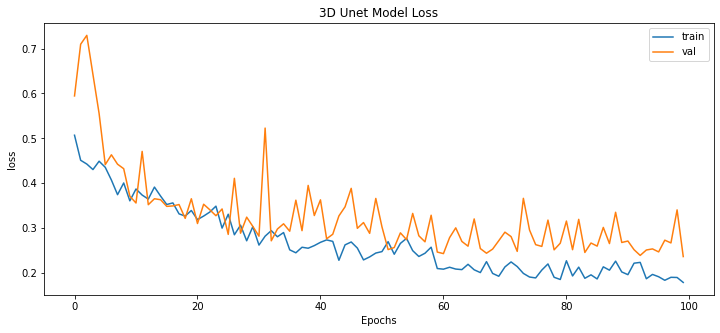

In [19]:
model, optimizer = get_model_and_optimizer(device)
train_whole_images = True
num_epochs = 100

weights_stem = 'whole_images'
train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem)


In [20]:
batch = next(iter(validation_loader))
model.eval()
model.load_state_dict(torch.load(os.path.join(dataset_dir, "best_metric_model.pth")))
inputs = batch['mri'][DATA].to(device)
with torch.no_grad():
    logits = forward(model, inputs)
labels = logits.argmax(dim=CHANNELS_DIMENSION, keepdim=True)

In [21]:
def plot_image_and_mask_evaluate(batch_data, predicted):
    valid_img = batch_data['mri'][DATA]
    valid_mask = batch_data['mask'][DATA]
    j = randint(0, len(valid_img)-1)
    valid_img_o = valid_img[j].cpu().numpy()
    valid_mask_o = valid_mask[j].cpu().numpy()
    predicted_label = predicted[j].cpu().numpy().astype(np.uint8)

    fig, axs = plt.subplots(len(valid_img_o[0,0,0,:]),4, figsize=(14,30))
    count = 0
    for i in range(len(valid_img_o[0,0,0,:])):
        img_original = np.transpose(valid_img_o[:,:,:,i],(1,2,0))
        img_prediction = np.transpose(valid_img_o[:,:,:,i],(1,2,0))
        original_mask = np.transpose(valid_mask_o[:,:,:,i],(1,2,0))
        predicted_mask = np.transpose(predicted_label[:,:,:,i],(1,2,0))

        axs[count][0].title.set_text("MRI T2 WI rectal") # set title
        axs[count][0].imshow(img_original, cmap='gray') # show MRI 
        axs[count][1].title.set_text("Ground Truth") # plot title on the mask 
        axs[count][1].imshow(original_mask, cmap='gray') # Show ground truth mask
        axs[count][2].title.set_text('AI predicted mask')
        axs[count][2].imshow(predicted_mask, cmap='gray') # Show predicted mask
        #overlay original mask with MRI
        overay_mask = original_mask.copy()
        overay_mask[predicted_mask.copy()==1] = 5
        substract_b_a = predicted_mask.copy() - original_mask.copy()
        overay_mask[substract_b_a.copy()==1] = 1
        axs[count][3].imshow(overay_mask, cmap='Reds',alpha = 1)
        axs[count][3].title.set_text('Overay GT and predicted mask')
        count += 1
    fig.tight_layout()
    return print("prediction completed")

prediction completed


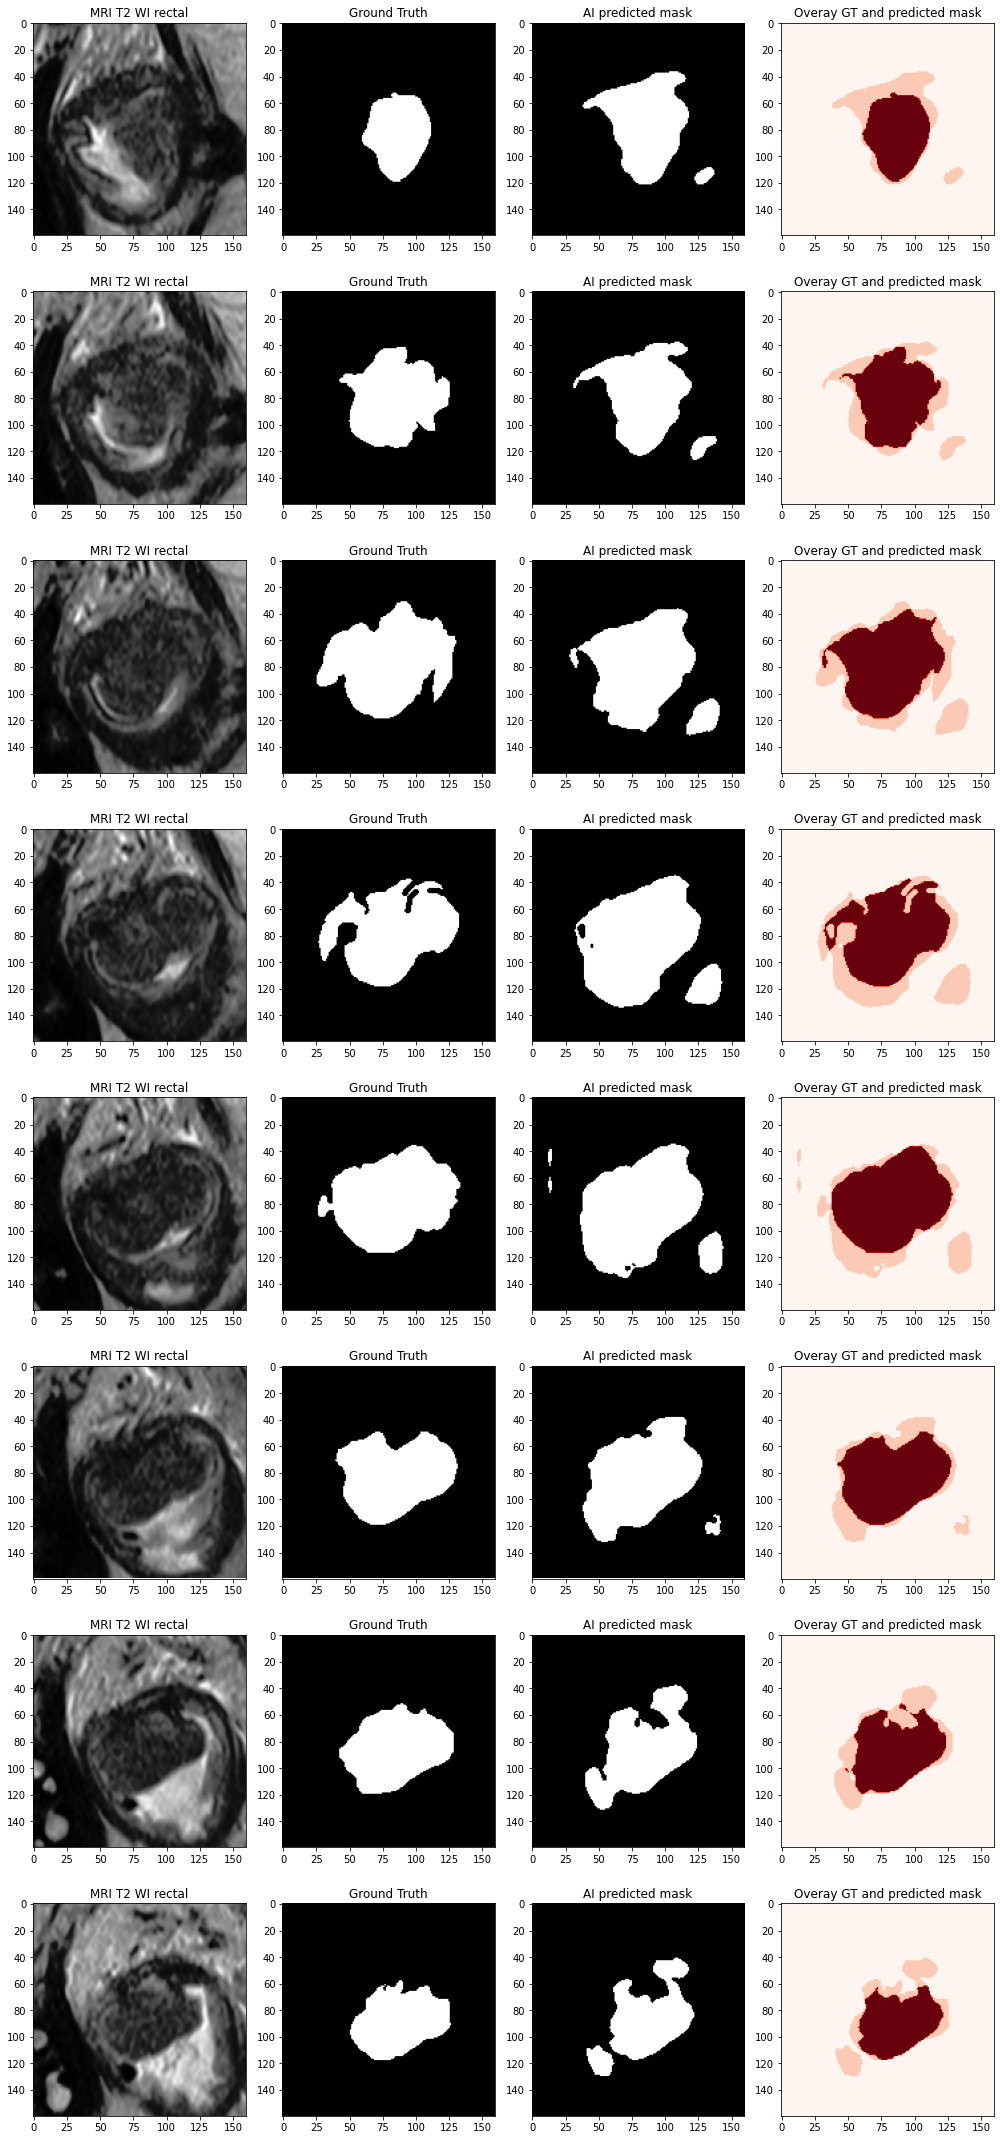

In [22]:
plot_image_and_mask_evaluate(batch, labels)